# Supernova distances and redshifts (Part 1)

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

In [1]:
import numpy as np
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

In [2]:
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\venv\Utilities")
from Utilities import plot_settings
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Raw Data')

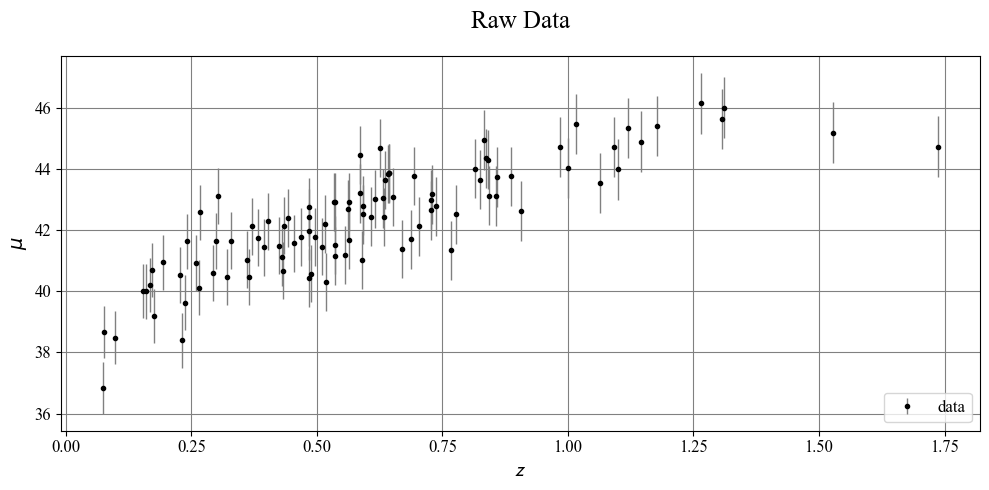

In [3]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$\mathcal{z}$")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.title('Raw Data')

In [4]:
import random
random_seed = 54

np.random.seed(random_seed)
random.seed(random_seed)

## Linear Regression

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
x_train, x_test, y_train, y_test, dmu_train, dmu_test = train_test_split(z_sample, mu_sample, dmu, test_size=0.2, random_state=42)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import chi2

In [8]:
lin_reg = LinearRegression()
lin_reg.fit(z_sample.reshape(-1,1), mu_sample.reshape(-1,1))

LinearRegression()

In [9]:
q = lin_reg.intercept_
m = lin_reg.coef_

residuals = np.abs(mu_sample - (m*z_sample + q)[0])

In [10]:
chi_squared = np.sum(((mu_sample - (m*z_sample + q)[0]) / dmu)**2)
# Optional: Reduced chi-squared
dof = len(mu_sample) - 2  # degrees of freedom: N - number of parameters (slope + intercept)
reduced_chi_squared = chi_squared / dof

Text(0.5, 1.0, 'Residuals')

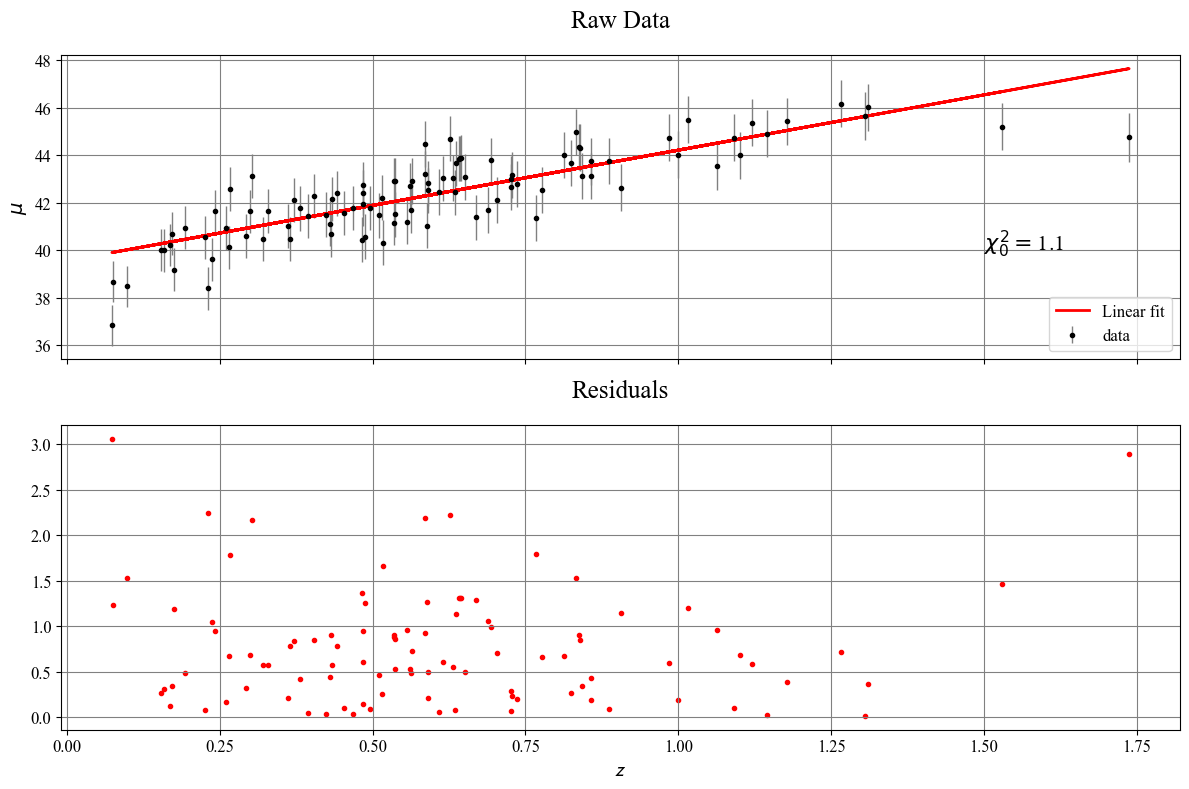

In [11]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(12,8))
axs[0].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
axs[0].plot(z_sample, (m*z_sample + q)[0], lw=2, color='red', label='Linear fit')
axs[0].set_ylabel(r"$\mu$")
axs[0].set_title('Raw Data')
axs[0].legend(loc='lower right')
axs[0].text(
    1.5, 40, s=r"$\chi^{2}_{0}=$"+f"{reduced_chi_squared:.2}",
    fontsize=16
)

axs[1].set_xlabel(r"$\mathcal{z}$")
axs[1].scatter(z_sample, residuals, marker='.', color='red')
axs[1].set_title('Residuals')

This fit shows high residuals in all the measured redshift spectrum.
## Polynomial Regression

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import root_mean_squared_error

Degree 2 → Test MSE: 0.954


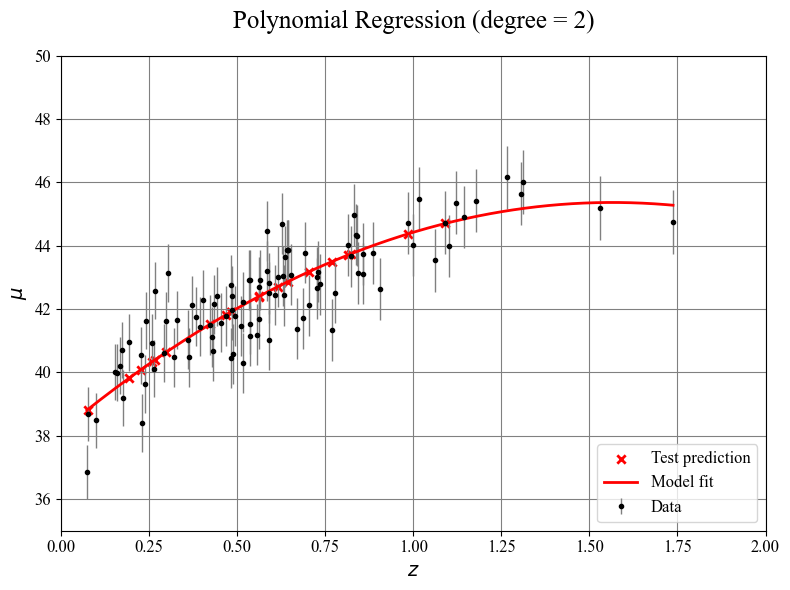

Degree 4 → Test MSE: 0.911


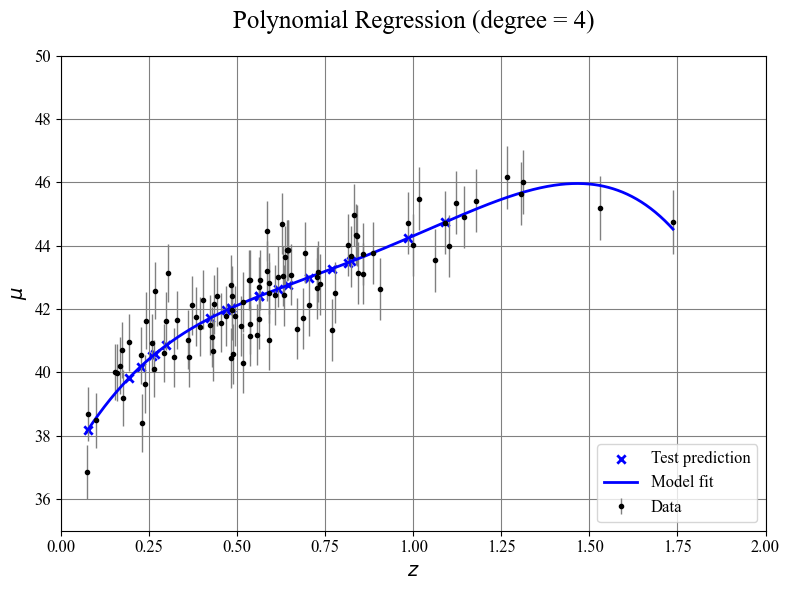

Degree 10 → Test MSE: 0.969


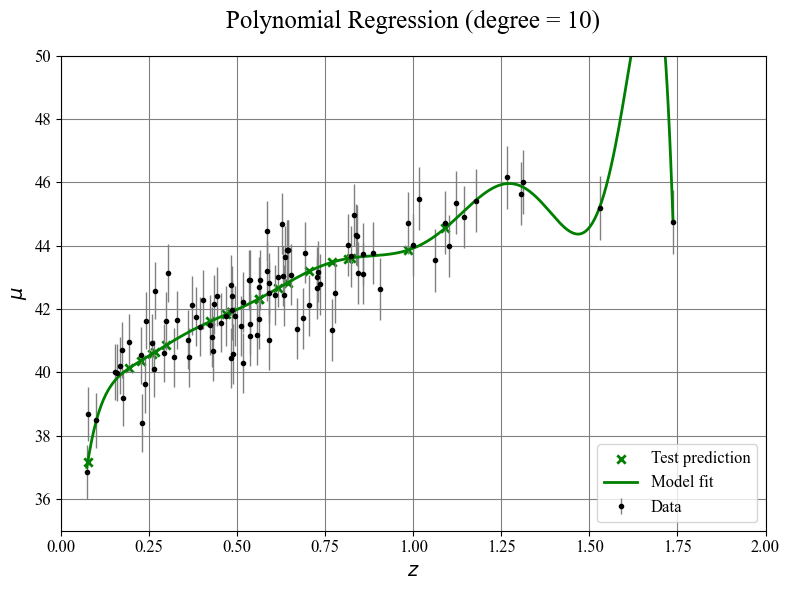

Degree 100 → Test MSE: 1.516


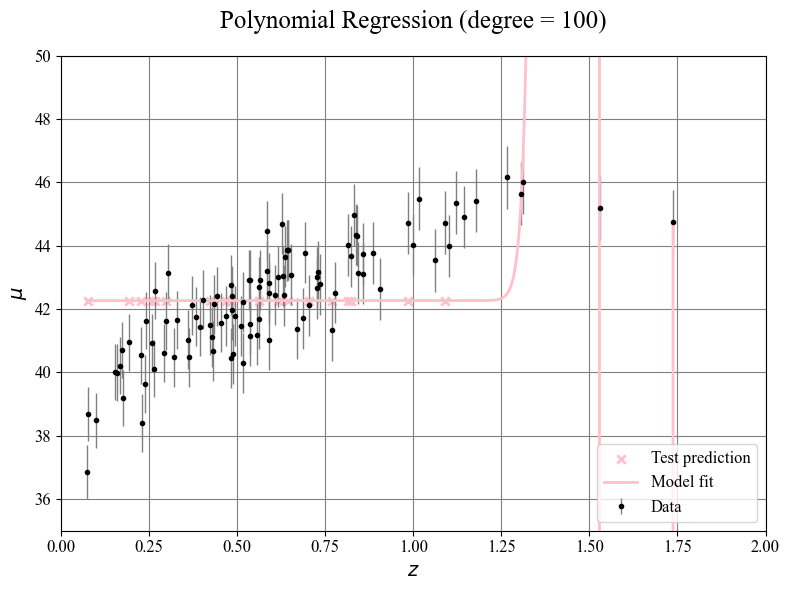

In [13]:
degrees = [2, 4, 10, z_sample.size]
colors = ['red', 'blue', 'green', 'pink']

for deg, color in zip(degrees, colors):
    
    poly = PolynomialFeatures(degree=deg, include_bias=False)

    # Transform training and test sets
    X_train_poly = poly.fit_transform(x_train.reshape(-1, 1))
    X_test_poly = poly.transform(x_test.reshape(-1, 1))

    # Fit model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Predict on train and test
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    # Calculate and print metrics
    mse = root_mean_squared_error(y_test, y_test_pred)
    print(f"Degree {deg} → Test MSE: {mse:.3f}")

    # === Smooth curve from model ===
    z_plot = np.linspace(min(z_sample), max(z_sample), 500).reshape(-1, 1)
    z_plot_poly = poly.transform(z_plot)
    mu_fit = model.predict(z_plot_poly)

    # === Plot ===
    plt.figure(figsize=(8, 6))
    # Error bars for full sample
    plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')
    
    # Test predictions (as points)
    plt.scatter(x_test, y_test_pred, marker='x', color=color, label='Test prediction')

    # Model fit curve (smooth)
    plt.plot(z_plot, mu_fit, color=color, lw=2, label='Model fit')

    # Labels and styling
    plt.xlabel(r"$z$")
    plt.ylabel(r"$\mu$")
    plt.title(f'Polynomial Regression (degree = {deg})')
    plt.legend(loc='lower right')
    plt.xlim(0,2)
    plt.ylim(35,50);
    plt.show()

Based on the four degrees I picked, the best fit is the second degree polynomial; it is a good compromise between model complexity, degrees of freedom and how much the fit line intercepts data points.\
Using low degrees polynomials determines underfitting, meaing less of the data structure is grabbed from the fit line. On the other hand using too high degree polynomials determines overfitting, i.e. the model gets extremely good at training but its predictive power decreases.\
I can do better, cross validate on the number of degrees!

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [15]:
# Create pipeline
pipe = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('linreg', LinearRegression())
])

# Define parameter grid
param_grid = {
    'poly__degree': np.linspace(1,20,10, dtype=int)  # your degree values
}

In [34]:
from sklearn.model_selection import KFold, cross_val_score

In [17]:
# Perform grid search with cross-validation
custom_cv = KFold(n_splits=5, shuffle=True)
grid = GridSearchCV(pipe, param_grid, cv=custom_cv, scoring='neg_mean_squared_error', return_train_score=True)
grid.fit(x_train.reshape(-1, 1), y_train)
# Best model and degree
best_model = grid.best_estimator_
best_degree = grid.best_params_['poly__degree']
print(f"Best polynomial degree: {best_degree}")

Best polynomial degree: 3


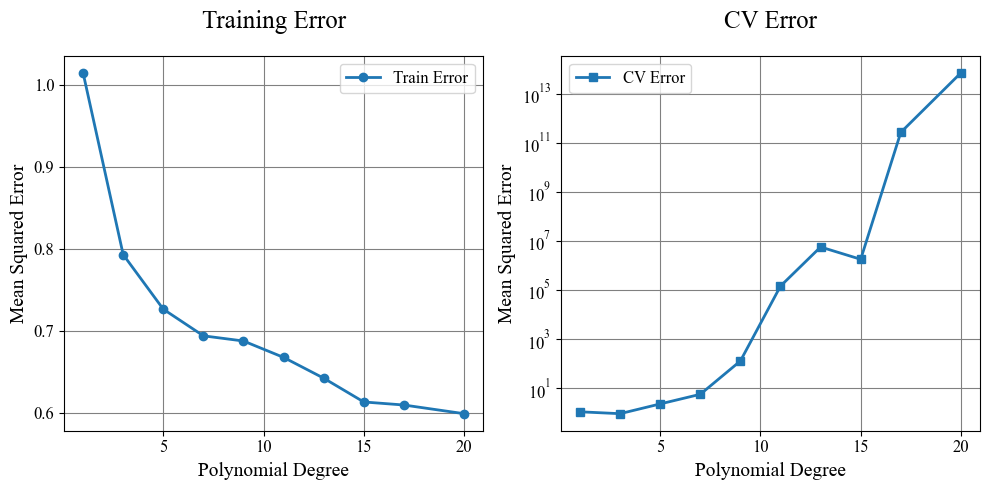

In [18]:
# Extract degrees, train and test scores
degrees = grid.cv_results_['param_poly__degree'].data.astype(int)
mean_train_scores = -grid.cv_results_['mean_train_score']  # Convert from negative MSE
mean_test_scores = -grid.cv_results_['mean_test_score']

# Plotting

fig, axs = plt.subplots(1,2)

axs[0].plot(degrees, mean_train_scores, label='Train Error', marker='o')
#plt.plot(degrees, mean_test_scores, label='CV Error', marker='s')
axs[0].set_xlabel('Polynomial Degree')
axs[0].set_ylabel('Mean Squared Error')
axs[0].set_title('Training Error')
axs[0].legend()

axs[1].plot(degrees, mean_test_scores, label='CV Error', marker='s')
axs[1].set_xlabel('Polynomial Degree')
axs[1].set_ylabel('Mean Squared Error')
axs[1].set_title('CV Error')
axs[1].legend()
axs[1].set_yscale('log')


As showed in the plots above, as the polynomial degree increases, the training MSE decreases since the number of parameters grows and thus it is easier for the model to best fit the data. At the same time CV MSE increases very rapidely! With a polynomial degree as low as 6 the model is greatly overfitting the data!

Test MSE with best degree: 0.953


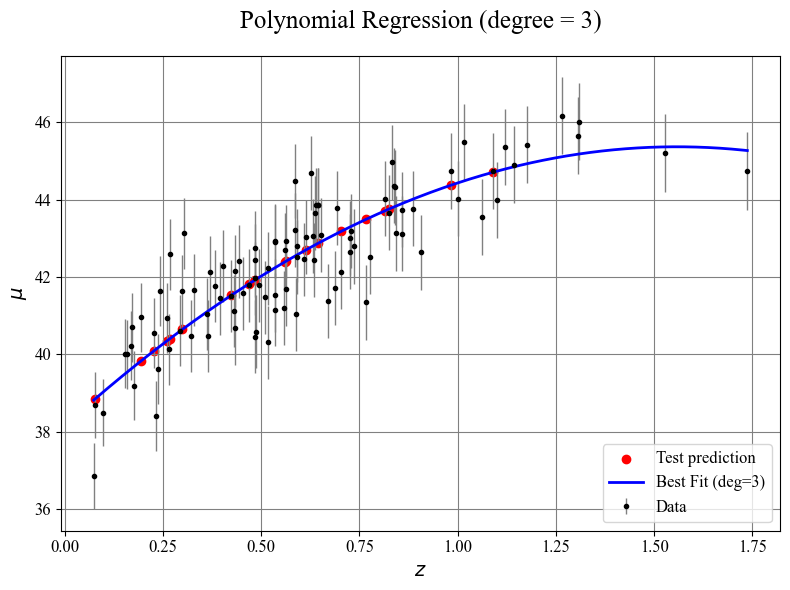

In [19]:
# Predict on test set
y_test_pred = best_model.predict(x_test.reshape(-1, 1))
mse_test = root_mean_squared_error(y_test, y_test_pred)
print(f"Test MSE with best degree: {mse_test:.3f}")

# === Plot best model ===
z_plot = np.linspace(min(z_sample), max(z_sample), 500).reshape(-1, 1)
mu_fit = best_model.predict(z_plot)

plt.figure(figsize=(8, 6))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')
plt.scatter(x_test, y_test_pred, color='red', label='Test prediction')
plt.plot(z_plot, mu_fit, color='blue', lw=2, label=f'Best Fit (deg={best_degree})')
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu$")
plt.title(f'Polynomial Regression (degree = {best_degree})')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Let's see what happens adding new z points

In [20]:
new_z_sample, new_mu_sample, new_dmu = generate_mu_z(1000, random_state=1234)

In [21]:
idxs = np.random.choice(np.linspace(0,len(new_z_sample),len(new_z_sample), dtype=int)[new_z_sample > max(z_sample)], 20)

In [22]:
add_z_sample = new_z_sample[idxs]
add_mu_sample = new_mu_sample[idxs]

In [23]:
# Fit was already done — assuming `best_model` is the result of GridSearchCV
poly = best_model.named_steps['poly']
model = best_model.named_steps['linreg']

# Get polynomial features for z_plot
z_plot = np.linspace(min(z_sample), max(z_sample), 500).reshape(-1, 1)
X_plot_poly = poly.transform(z_plot)

# Get design matrix of training data
X_train_poly = poly.transform(x_train.reshape(-1, 1))

# Predict mean
mu_fit = model.predict(X_plot_poly)

# === Compute prediction uncertainty ===
# Residuals
residuals = y_train - model.predict(X_train_poly)
dof = X_train_poly.shape[0] - X_train_poly.shape[1]  # degrees of freedom
mse = np.sum(residuals**2) / dof  # mean squared error

# Covariance matrix: (XᵗX)^(-1) * MSE
XtX_inv = np.linalg.inv(X_train_poly.T @ X_train_poly)
cov_matrix = mse * XtX_inv

# Variance of prediction: diag(X*Cov*Xᵗ)
pred_var = np.sum(X_plot_poly @ cov_matrix * X_plot_poly, axis=1)
pred_std = np.sqrt(pred_var)

# 1σ confidence bands
mu_upper = mu_fit + pred_std
mu_lower = mu_fit - pred_std

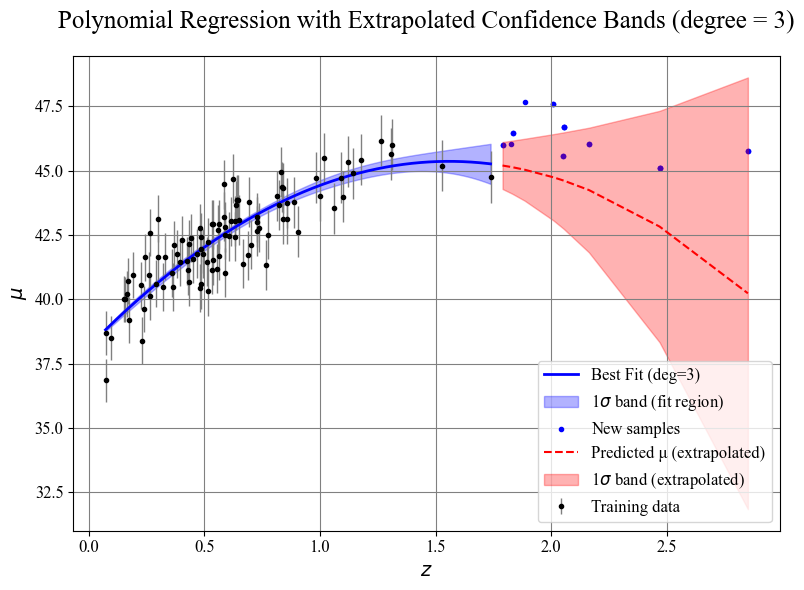

In [24]:
# === Transform add_z_sample ===
add_X_poly = poly.transform(add_z_sample.reshape(-1, 1))
add_mu_fit = model.predict(add_X_poly)

residuals = y_train - model.predict(X_train_poly)
dof = X_train_poly.shape[0] - X_train_poly.shape[1]  # degrees of freedom
mse = np.sum(residuals**2) / dof  # mean squared error

# Covariance matrix: (XᵗX)^(-1) * MSE
XtX_inv = np.linalg.inv(X_train_poly.T @ X_train_poly)
cov_matrix = mse * XtX_inv

# === Compute standard deviation of predictions ===
add_pred_var = np.sum(add_X_poly @ cov_matrix * add_X_poly, axis=1)
add_pred_std = np.sqrt(add_pred_var)

# === Sort add_z_sample for plotting with fill_between ===
sorted_idx = np.argsort(add_z_sample)
add_z_sorted = add_z_sample[sorted_idx]
add_mu_sorted = add_mu_fit[sorted_idx]
add_std_sorted = add_pred_std[sorted_idx]

add_mu_upper = add_mu_sorted + add_std_sorted
add_mu_lower = add_mu_sorted - add_std_sorted

# 1σ confidence bands
mu_upper = mu_fit + pred_std
mu_lower = mu_fit - pred_std

# === Plot ===
plt.figure(figsize=(8, 6))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Training data')
plt.plot(z_plot, mu_fit, color='blue', lw=2, label=f'Best Fit (deg={best_degree})')
plt.fill_between(z_plot.ravel(), mu_lower, mu_upper, color='blue', alpha=0.3, label=r'1$\sigma$ band (fit region)')

# === Fill prediction band on new z's ===
plt.scatter(add_z_sample, add_mu_sample, marker='.', color='blue', label='New samples')
plt.plot(add_z_sorted, add_mu_sorted, 'r--', lw=1.5, label='Predicted μ (extrapolated)')
plt.fill_between(add_z_sorted, add_mu_lower, add_mu_upper, color='red', alpha=0.3, label=r'1$\sigma$ band (extrapolated)')

# Labels and styling
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu$")
plt.title(f'Polynomial Regression with Extrapolated Confidence Bands (degree = {best_degree})')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


This would not go well...

## Basis Function Regression (Gaussians)

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianBasis(BaseEstimator, TransformerMixin):
    def __init__(self, n_centers=10, sigma=1.0):
        self.n_centers = n_centers
        self.sigma = sigma

    def fit(self, X, y=None):
        X = X.reshape(-1, 1)
        self.centers_ = np.linspace(X.min(), X.max(), self.n_centers).reshape(-1, 1)
        return self

    def transform(self, X):
        X = X.reshape(-1, 1)
        return np.exp(-((X - self.centers_.T) ** 2) / (2 * self.sigma ** 2))

# Create pipeline
pipe = Pipeline([
    ('gauss', GaussianBasis()),  # Your custom Gaussian transformer
    ('linreg', LinearRegression())
])

# Define parameter grid
param_grid = {
    'gauss__n_centers': list(np.linspace(1,20,20, dtype=int)),
    'gauss__sigma': list(np.power(10,np.linspace(-3,3,7)))
}

# Grid search with CV
grid = GridSearchCV(pipe, param_grid, cv=custom_cv, scoring='neg_mean_squared_error')
grid.fit(x_train.reshape(-1, 1), y_train)

# Best model and parameters
best_model = grid.best_estimator_
best_params = grid.best_params_
print(f"Best Gaussian basis parameters: {best_params} | Best score")


Best Gaussian basis parameters: {'gauss__n_centers': np.int64(2), 'gauss__sigma': np.float64(10.0)} | Best score


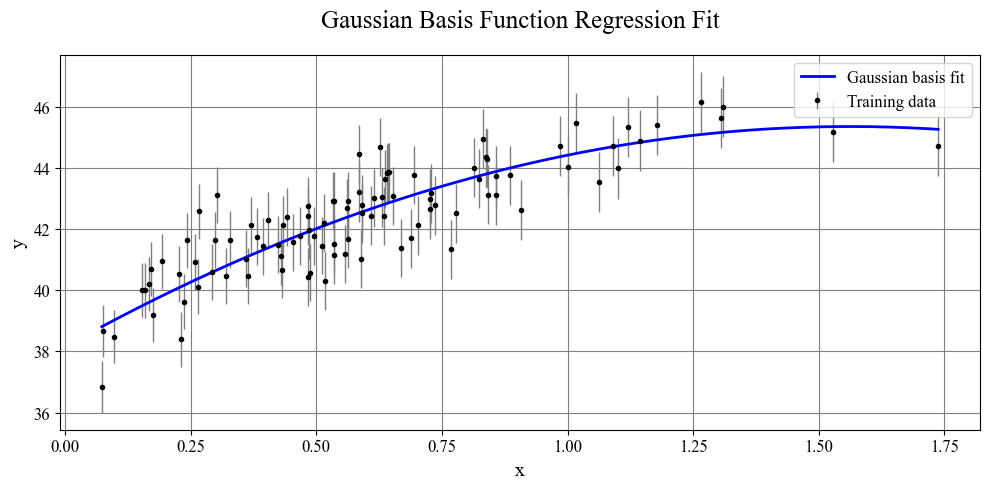

In [26]:
# Predict on a smooth range for plotting
x_plot = np.linspace(x_train.min(), x_train.max(), 500).reshape(-1, 1)
y_plot = best_model.predict(x_plot)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Training data')
plt.plot(x_plot, y_plot, color='blue', label='Gaussian basis fit')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian Basis Function Regression Fit')
plt.legend()
plt.grid(True)
plt.show()


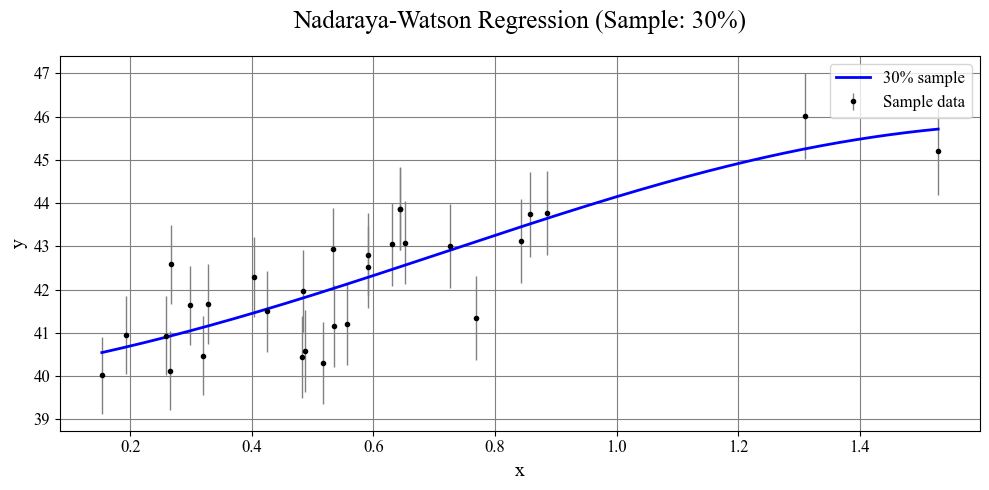

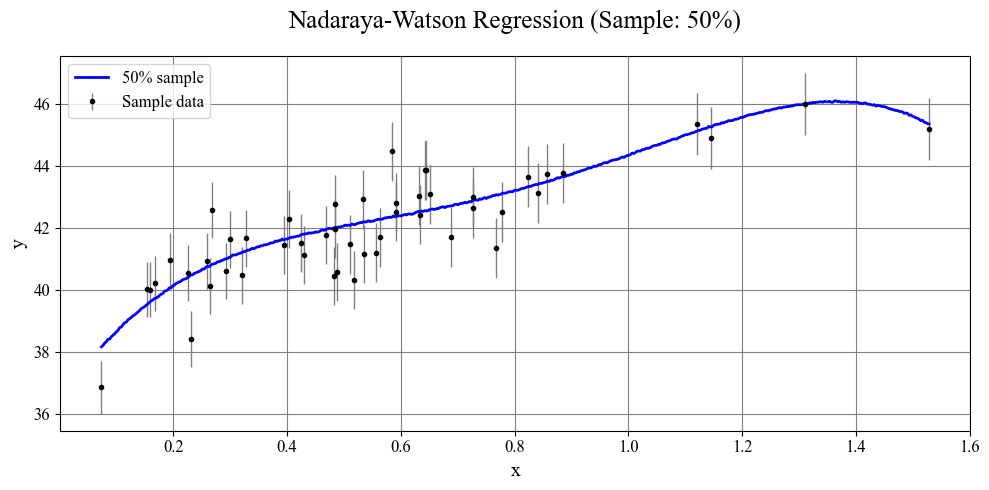

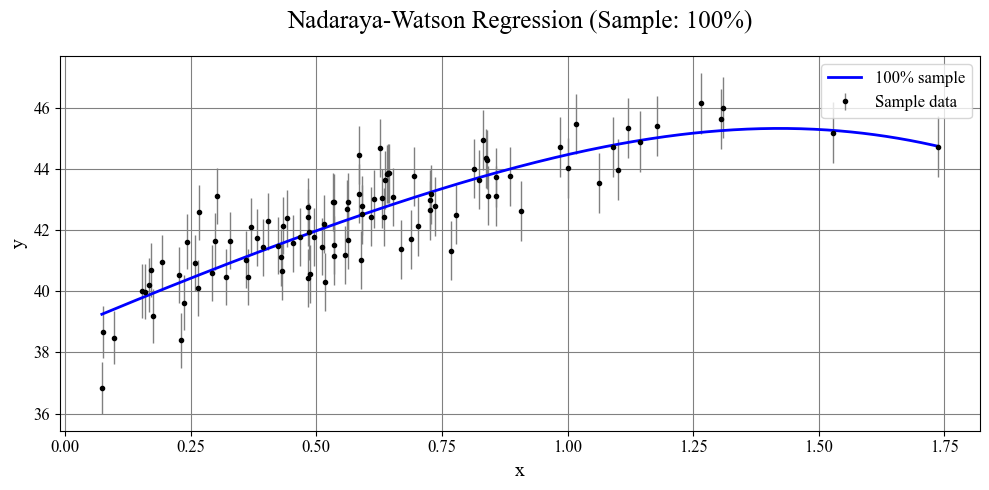

In [27]:
percs = [0.3, 0.5, 1.0]
random_seed = 54

np.random.seed(random_seed)
random.seed(random_seed)

# Calcolo una sola volta gli indici, con il massimo numero richiesto
N_max = int(max(percs) * z_sample.size)
all_idxs = np.random.choice(z_sample.size, N_max, replace=False)

for p in percs:
    N = int(p * z_sample.size)
    idxs = all_idxs[:N]  # prendi solo i primi N indici

    new_z = z_sample[idxs]
    new_mu = mu_sample[idxs]
    new_dmu = dmu[idxs]

    # Grid search over NW regressor
    grid = GridSearchCV(pipe, param_grid, cv=custom_cv, scoring='neg_mean_squared_error')
    grid.fit(new_z.reshape(-1, 1), new_mu)

    best_model = grid.best_estimator_

    # Predict for smooth curve
    x_plot = np.linspace(new_z.min(), new_z.max(), 500).reshape(-1, 1)
    y_plot = best_model.predict(x_plot)

    plt.errorbar(new_z, new_mu, new_dmu, fmt='.k', ecolor='gray', lw=1, label='Sample data')
    plt.plot(x_plot, y_plot, color='blue', label=f'{int(p*100)}% sample')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Nadaraya-Watson Regression (Sample: {int(p*100)}%)')
    plt.legend()
    plt.show()


## Kernel regression (Nadaraya-Watson)

In [28]:
from sklearn.base import RegressorMixin

In [29]:
class NadarayaWatson(BaseEstimator, RegressorMixin):
    def __init__(self, bandwidth=1.0):
        self.bandwidth = bandwidth

    def fit(self, X, y):
        self.X_train_ = X.reshape(-1, 1)
        self.y_train_ = y
        return self

    def predict(self, X):
        X = X.reshape(-1, 1)
        K = self._gaussian_kernel(X, self.X_train_)
        weights = K / K.sum(axis=1, keepdims=True)
        return weights.dot(self.y_train_)

    def _gaussian_kernel(self, X, X_train):
        # Pairwise squared Euclidean distances
        dists = (X - X_train.T)**2
        return np.exp(-dists / (2 * self.bandwidth ** 2))

In [30]:
# Define the bandwidth values to try
param_grid = {'bandwidth': list(np.power(10, np.linspace(-2,1,20)))}

# Perform 5-fold cross-validation
grid = GridSearchCV(NadarayaWatson(), param_grid, cv=custom_cv, scoring='neg_mean_squared_error')

# Fit on training data
grid.fit(x_train.reshape(-1, 1), y_train)

# Best model and bandwidth
best_model = grid.best_estimator_
best_bandwidth = grid.best_params_['bandwidth']
print("Best bandwidth:", best_bandwidth)


Best bandwidth: 0.08858667904100823


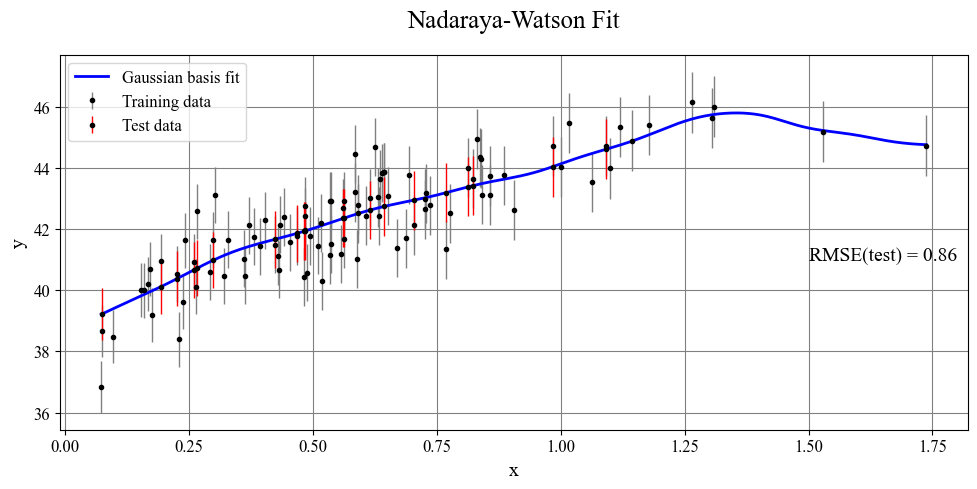

In [31]:
# Predict on a smooth range for plotting
x_plot = np.linspace(x_train.min(), x_train.max(), 500).reshape(-1, 1)
y_plot = best_model.predict(x_plot)
y_pred = best_model.predict(x_test.reshape(-1,1))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Training data')
plt.plot(x_plot, y_plot, color='blue', label='Gaussian basis fit')
plt.errorbar(x_test, y_pred, dmu_test, fmt='.k', ecolor='red', lw=1, label='Test data')
mse = root_mean_squared_error(y_test, y_pred)
plt.text(
    1.5, 41,s=f'RMSE(test) = {mse:.2}', fontsize=14
)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Nadaraya-Watson Fit')
plt.legend()
plt.grid(True)
plt.show()

Implementing Uber Loss Function

In [28]:
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, RegressorMixin

In [29]:
class NadarayaWatson(BaseEstimator, RegressorMixin):
    def __init__(self, bandwidth=1.0, epsilon=1e-6):
        self.bandwidth = bandwidth
        self.epsilon = epsilon

    def fit(self, X, y):
        self.X_ = np.asarray(X).reshape(-1, 1)
        self.y_ = np.asarray(y)
        return self

    def predict(self, X):
        X = np.asarray(X).reshape(-1, 1)
        weights = np.exp(-((X - self.X_.T) ** 2) / (2 * self.bandwidth ** 2))
        weights_sum = weights.sum(axis=1, keepdims=True)
        weights /= weights_sum
        return np.dot(weights, self.y_)

    def score(self, X, y):
        y_pred = self.predict(X)
        # Negative Uber loss (since GridSearchCV maximizes score)
        return -np.mean(np.sqrt((y - y_pred) ** 2 + self.epsilon))

In [34]:
param_grid = {
    'bandwidth': np.power(10, np.linspace(-2, 1, 10)),
    'epsilon': [1e-8, 1e-6, 1e-4, 1e-2]
}

grid = GridSearchCV(NadarayaWatson(), param_grid, cv=custom_cv)
grid.fit(x_train.reshape(-1, 1), y_train)

print("Best bandwidth:", grid.best_params_['bandwidth'])
print("Best epsilon:", grid.best_params_['epsilon'])

Best bandwidth: 0.046415888336127774
Best epsilon: 1e-08


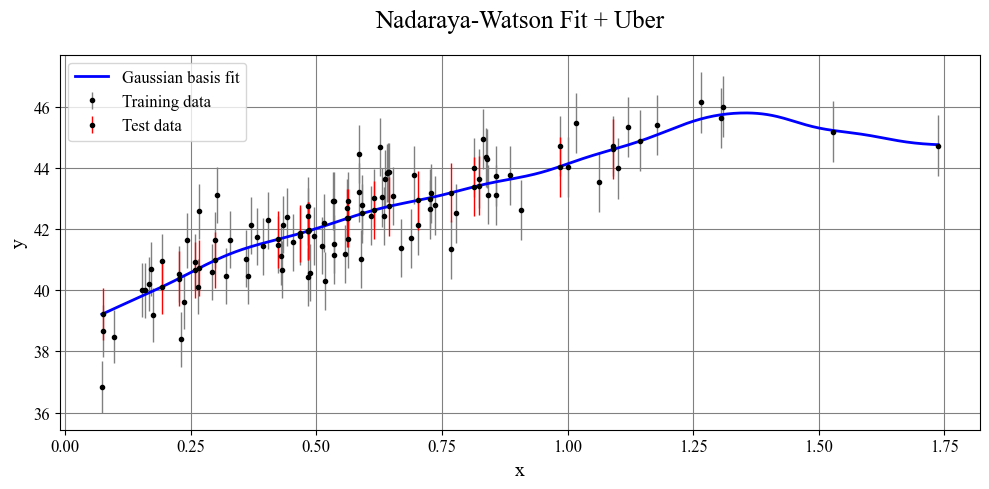

In [35]:
# Predict on a smooth range for plotting
x_plot = np.linspace(x_train.min(), x_train.max(), 500).reshape(-1, 1)
y_plot = best_model.predict(x_plot)
y_pred = best_model.predict(x_test.reshape(-1,1))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Training data')
gbf = plt.plot(x_plot, y_plot, color='blue', label='Gaussian basis fit')
plt.errorbar(x_test, y_pred, dmu_test, fmt='.k', ecolor='red', lw=1, label='Test data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Nadaraya-Watson Fit + Uber')
plt.legend()
plt.grid(True)
plt.show()

## Part 2

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- But check out what's available in the kernels submodule of sklearn.gaussian_process
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

In [36]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, RationalQuadratic
from sklearn.preprocessing import StandardScaler

In [37]:
Kernels = []

In [38]:
def do_GPR_reg(kern, scaler, X_scaled, plot_scaled=False, plot_scaled_back=False):
    GPR = GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=10)
    GPR.fit(X_scaled.T[0].reshape(-1,1), X_scaled.T[1].reshape(-1,1))
    
    if plot_scaled:
        # Predict on a smooth range for plotting
        x_plot = np.linspace(X_scaled.T[0].min(), X_scaled.T[0].max(), 500)
        y_plot, std = GPR.predict(x_plot.reshape(-1, 1), return_std=True)
        
        plt.scatter(X_scaled.T[0], X_scaled.T[1], marker='.', color='gray',label='Training data')
        plt.plot(x_plot, y_plot, color='blue', label='GPR fit')
        plt.fill_between(x_plot, y_plot-std, y_plot+std, color='blue', alpha=0.5, label=r'$1-\sigma$')
        plt.fill_between(x_plot, y_plot-2*std, y_plot+2*std, color='blue', alpha=0.2, label=r'$2-\sigma$')
        plt.xlabel(r'Scaled $z$')
        plt.ylabel(r'Scaled $\mu$')
        plt.title('Gaussian Process Regression (Scaled data))')
        plt.legend()
        plt.show()
        
    if plot_scaled_back:
        # Generate x values for plotting
        x_plot = np.linspace(X_scaled.T[0].min(), X_scaled.T[0].max(), 500).reshape(-1, 1)

        # Predict mean and std from GPR
        y_pred_scaled, y_std_scaled = GPR.predict(x_plot, return_std=True)

        # Stack mean prediction to shape (500, 2) for inverse transform
        temp_mean = np.hstack([x_plot, y_pred_scaled.reshape(-1, 1)])
        Y_pred = scaler.inverse_transform(temp_mean)

        # Create upper and lower bounds for inverse transform (mean ± std)
        temp_upper = np.hstack([x_plot, (y_pred_scaled + y_std_scaled).reshape(-1, 1)])
        temp_lower = np.hstack([x_plot, (y_pred_scaled - y_std_scaled).reshape(-1, 1)])

        temp_upper_2s = np.hstack([x_plot, (y_pred_scaled + 2*y_std_scaled).reshape(-1, 1)])
        temp_lower_2s = np.hstack([x_plot, (y_pred_scaled - 2*y_std_scaled).reshape(-1, 1)])

        Y_upper = scaler.inverse_transform(temp_upper)
        Y_lower = scaler.inverse_transform(temp_lower)

        Y_upper_2s = scaler.inverse_transform(temp_upper_2s)
        Y_lower_2s = scaler.inverse_transform(temp_lower_2s)

        # Extract the values
        z_scaled_back_fit = Y_pred.T[0]
        mu_scaled_back_fit = Y_pred.T[1]


        # Also get the training data back to original scale
        Y = scaler.inverse_transform(np.vstack([X_scaled.T[0], X_scaled.T[1]]).T)


        # Plot everything
        plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Training data')
        plt.plot(z_scaled_back_fit, mu_scaled_back_fit, color='blue', label='GPR fit')
        plt.fill_between(z_scaled_back_fit, Y_lower.T[1], Y_upper.T[1], color='blue', alpha=0.5, label=r"$1-\sigma$")
        plt.fill_between(z_scaled_back_fit, Y_lower_2s.T[1], Y_upper_2s.T[1], color='blue', alpha=0.2, label=r"$2-\sigma$")
        plt.xlabel(r'$z$')
        plt.ylabel(r'$\mu$')
        plt.title('GPR fit - '+str(kern))
        plt.legend()
        plt.grid(True)
        plt.show()

def select_best_kernel(X, y, kernels, custom_cross_validator, scoring='neg_mean_squared_error', n_restarts_optimizer=10):
    """
    Cross-validate multiple kernels with hyperparameter optimization in each fold.

    Parameters:
    -----------
    X : array-like, shape (n_samples,)
        Input features (1D).
    y : array-like, shape (n_samples,)
        Target values.
    kernels : list of sklearn.gaussian_process.kernels.Kernel
        List of kernel objects to evaluate.
    cv : int, default=5
        Number of cross-validation folds.
    scoring : str, default='neg_mean_squared_error'
        Scoring metric used by cross_val_score.
    n_restarts_optimizer : int, default=10
        Number of restarts for kernel hyperparameter optimizer during fitting.

    Returns:
    --------
    best_kernel : sklearn.gaussian_process.kernels.Kernel
        The kernel with the best average CV score.
    scores_dict : dict
        Dictionary mapping kernel string repr to average CV score.
    """

    best_kernel = None
    best_score = -np.inf
    scores_dict = {}

    for kern in kernels:
        gpr = GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=n_restarts_optimizer)
        
        scores = cross_val_score(
            gpr,
            X.reshape(-1, 1),
            y,
            cv=custom_cross_validator,
            scoring=scoring,
            n_jobs=-1
        )
        mean_score = np.mean(scores)
        scores_dict[str(kern)] = mean_score
        print(f"Kernel: {kern}\n Mean CV Score: {mean_score:.5f}\n")

        if mean_score > best_score:
            best_score = mean_score
            best_kernel = kern

    print(f"Best kernel selected: {best_kernel}\nwith CV score: {best_score:.5f}")
    return best_kernel, scores_dict

In [39]:
X = np.vstack([z_sample, mu_sample]).T

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
Base_Kernels = [RBF(length_scale=0.001, length_scale_bounds=(1e-8, 1e8)) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e+1)),
           Matern(length_scale=0.001, length_scale_bounds=(1e-8, 1e8)) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e+1)),
           RationalQuadratic(length_scale=0.001) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e+1))]

In [42]:
# Define the regressor
gpr = GaussianProcessRegressor(kernel=Base_Kernels[0], n_restarts_optimizer=0)

# Define the param grid
param_grid = {
    'kernel__k1__length_scale': np.logspace(-3, -1, 10),
    'kernel__k2__noise_level': np.logspace(-1, 2, 5)
}

# Perform grid search
grid = GridSearchCV(gpr, param_grid, cv=custom_cv, scoring='neg_mean_squared_error')
grid.fit(x_train.reshape(-1, 1), y_train)

c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling f

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=GaussianProcessRegressor(kernel=RBF(length_scale=0.001) + WhiteKernel(noise_level=1)),
             param_grid={'kernel__k1__length_scale': array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ]),
                         'kernel__k2__noise_level': array([  0.1       ,   0.56234133,   3.16227766,  17.7827941 ,
       100.        ])},
             scoring='neg_mean_squared_error')

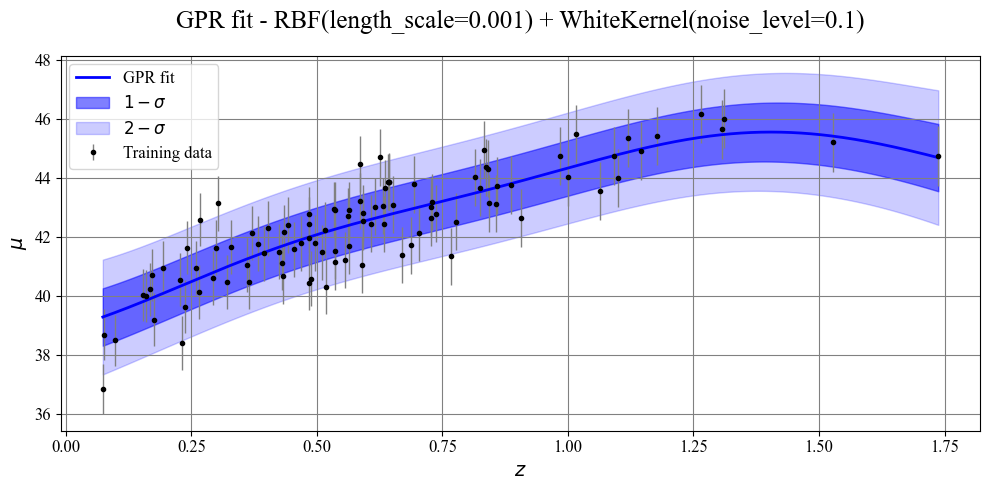

In [43]:
do_GPR_reg(grid.best_estimator_.kernel, scaler, X_scaled, plot_scaled_back=True)

In [44]:
Kernels.append(grid.best_estimator_.kernel)

In [45]:
# Define the regressor
gpr = GaussianProcessRegressor(kernel=Base_Kernels[1], n_restarts_optimizer=0)

# Define the param grid
param_grid = {
    'kernel__k1__length_scale': np.logspace(-3, -1, 10),
    'kernel__k1__nu': np.linspace(0.5, 2.5, 5),  
    'kernel__k2__noise_level': np.logspace(-1, 2, 5)
}


# Perform grid search
grid = GridSearchCV(gpr, param_grid, cv=custom_cv, scoring='neg_mean_squared_error')
grid.fit(x_train.reshape(-1, 1), y_train)

c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling f

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=GaussianProcessRegressor(kernel=Matern(length_scale=0.001, nu=1.5) + WhiteKernel(noise_level=1)),
             param_grid={'kernel__k1__length_scale': array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ]),
                         'kernel__k1__nu': array([0.5, 1. , 1.5, 2. , 2.5]),
                         'kernel__k2__noise_level': array([  0.1       ,   0.56234133,   3.16227766,  17.7827941 ,
       100.        ])},
             scoring='neg_mean_squared_error')

In [46]:
Kernels.append(grid.best_estimator_.kernel)

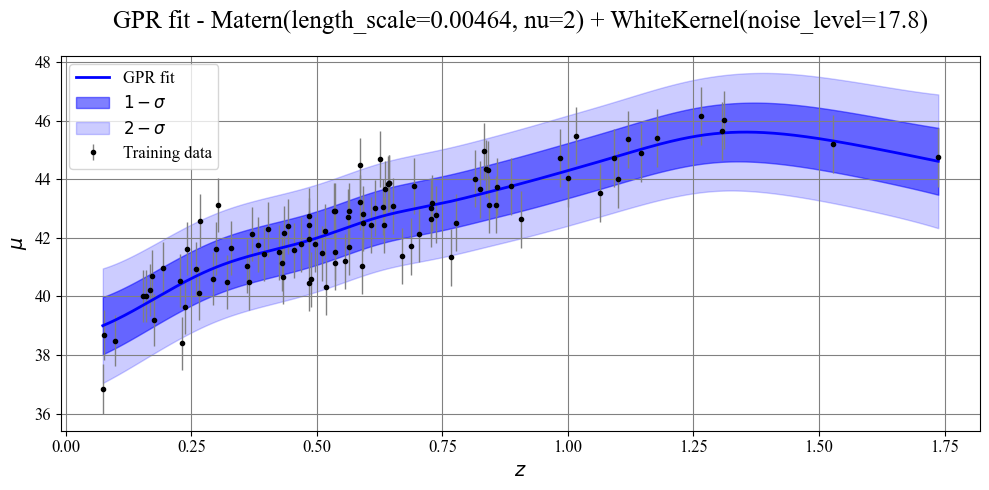

In [47]:
do_GPR_reg(grid.best_estimator_.kernel, scaler, X_scaled, plot_scaled_back=True)

In [48]:
# Define the regressor
gpr = GaussianProcessRegressor(kernel=Base_Kernels[2], n_restarts_optimizer=0)

# Define the param grid
param_grid = {
    'kernel__k1__alpha': np.linspace(1, 5, 10),
    'kernel__k1__length_scale': np.logspace(-3, -1, 10),
    'kernel__k2__noise_level': np.logspace(-1, 2, 5)
}

# Perform grid search
grid = GridSearchCV(gpr, param_grid, cv=custom_cv, scoring='neg_mean_squared_error')
grid.fit(x_train.reshape(-1, 1), y_train)

c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may fin

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=0.001) + WhiteKernel(noise_level=1)),
             param_grid={'kernel__k1__alpha': array([1.        , 1.44444444, 1.88888889, 2.33333333, 2.77777778,
       3.22222222, 3.66666667, 4.11111111, 4.55555556, 5.        ]),
                         'kernel__k1__length_scale': array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ]),
                         'kernel__k2__noise_level': array([  0.1       ,   0.56234133,   3.16227766,  17.7827941 ,
       100.        ])},
             scoring='neg_mean_squared_error')

In [49]:
Kernels.append(grid.best_estimator_.kernel)

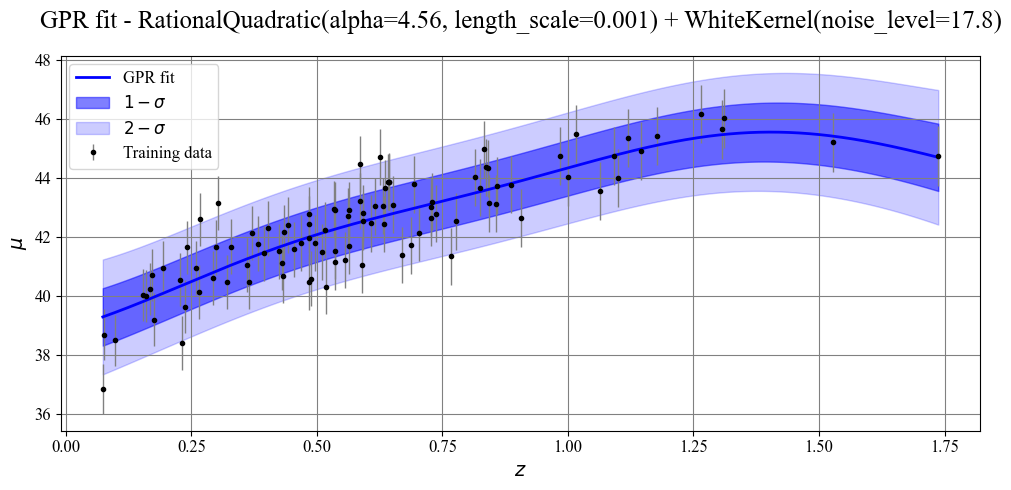

In [50]:
do_GPR_reg(grid.best_estimator_.kernel, scaler, X_scaled, plot_scaled_back=True)

In [51]:
best_kern, scores_dict = select_best_kernel(X_scaled.T[0], X_scaled.T[1], Kernels, custom_cv, n_restarts_optimizer=20)

Kernel: RBF(length_scale=0.001) + WhiteKernel(noise_level=0.1)
 Mean CV Score: -0.30554

Kernel: Matern(length_scale=0.00464, nu=2) + WhiteKernel(noise_level=17.8)
 Mean CV Score: -0.28581

Kernel: RationalQuadratic(alpha=4.56, length_scale=0.001) + WhiteKernel(noise_level=17.8)
 Mean CV Score: -0.30714

Best kernel selected: Matern(length_scale=0.00464, nu=2) + WhiteKernel(noise_level=17.8)
with CV score: -0.28581


In [52]:
best_kern

Matern(length_scale=0.00464, nu=2) + WhiteKernel(noise_level=17.8)

We have our kernel winner, Matern(length_scale=0.00464, nu=2) + WhiteKernel(noise_level=17.8).